# Combined model of RV and H$\alpha$

## Overall model is quasiperiodic in RV, quasiperiodic + extra squared exponential in H$\alpha$

<ul>
    <li>When doing a GP model of H$\alpha$ alone, I found that adding a long-term signal drift using an extra squared exponential kernel improved the fit. This may make sense because there could be a long-term activity cycle that is only partially covered by this dataset.</li>
    <li>I didn't find the extra signal drift necessary for the RV data; perhaps the long-term cycle manifests less in RV than in H$\alpha$? Not sure why.</li>
    <li>Period and decorrelation time are shared between two quasi-periodic kernels; amplitude and roughness can be different.</li>
</ul>

### 1. Get data:

In [1]:
'''THIS NOTEBOOK HAS A LONGTERM ON ONLY H-ALPHA'''
import numpy as np
from astropy.stats import LombScargle
import matplotlib.pyplot as plt
% matplotlib inline
# Read the data
date, rv, rverr, ha, haerr, nad, naderr, fwhm, fwhmerr, bis, biserr = \
    np.loadtxt("dbf_HARPS.txt", unpack=True, \
    usecols=[1,2,3,4,5,6,7,8,9,10,11], skiprows=21)
dateH, rvH, rverrH, haH, haerrH = \
    np.loadtxt("dbf_HIRES.txt", unpack=True, \
    usecols=[1,2,3,4,5])
first = date[0]
date -= first
dateH -= first
# Put together the HIRES and HARPS measurements of RV and Halpha
alldates = np.concatenate((date, dateH))
allRV = np.concatenate((rv, rvH))
allRVerr = np.concatenate((rverr, rverrH))
allha = np.concatenate((ha, haH))
allhaerr = np.concatenate((haerr, haerrH))
sub = np.argsort(alldates)
alldates = alldates[sub]
allRV = allRV[sub]
allRVerr = allRVerr[sub]
allha = allha[sub]
allhaerr = allhaerr[sub]
# Compute the periodograms
xiR, powR = LombScargle(alldates, allRV, allRVerr).autopower()
xiH, powH = LombScargle(alldates, allha, allhaerr).autopower()

### 2. Plot RV, H$\alpha$, and their periodograms:

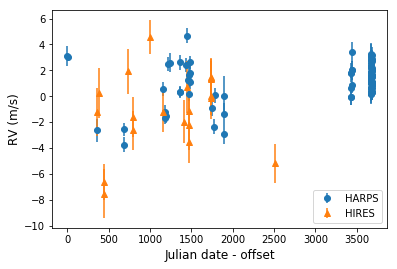

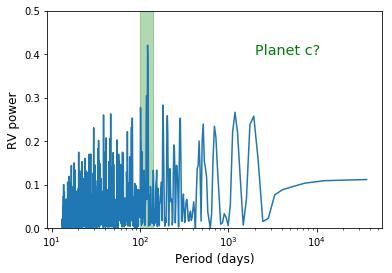

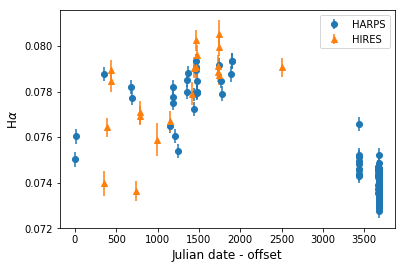

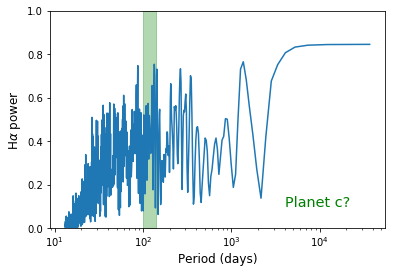

In [2]:
# Plot RV and periodogram
xpts = [101, 106, 111, 116, 121, 126, 131, 136, 141]
ypts = np.ones(9)
plt.figure()
plt.errorbar(date, rv, yerr=rverr, fmt='o', label="HARPS")
plt.errorbar(dateH, rvH, yerr=rverrH, fmt='^', label="HIRES")
plt.legend(loc="lower right")
plt.ylabel("RV (m/s)", fontsize='large')
plt.xlabel("Julian date - offset", fontsize="large")
plt.figure()
plt.plot(1./xiR, powR)
plt.fill_between(xpts, ypts, color="g", alpha=0.3)
plt.ylim([0,0.5])
plt.ylabel("RV power", fontsize="large")
plt.xlabel("Period (days)", fontsize="large")
plt.text(2000,0.4,"Planet c?", color="g", fontsize="x-large")
plt.xscale("log")
plt.figure()
plt.errorbar(date, ha, yerr=haerr, fmt='o', label="HARPS")
plt.errorbar(dateH, haH, yerr=haerrH, fmt='^', label="HIRES")
plt.legend(loc="upper right")
plt.ylabel(r"H$\alpha$", fontsize='large')
plt.xlabel("Julian date - offset", fontsize="large")
plt.figure()
plt.plot(1./xiH, powH)
plt.fill_between(xpts, ypts, color="g", alpha=0.3)
plt.ylim([0,1.])
plt.ylabel(r"H$\alpha$ power", fontsize="large")
plt.xlabel("Period (days)", fontsize="large")
plt.text(4000,0.1,"Planet c?", color="g", fontsize="x-large")
plt.xscale("log")

### 3. Set up the Gaussian processes with shared period and decorrelation time; find best-fit parameters:

In [3]:
# To install george: $ conda install -c conda-forge george
# Most of this code is borrowed from a tutorial in the george documentation:
# https://george.readthedocs.io/en/latest/tutorials/hyper/
from george import kernels
from george import GP
from george import modeling
from scipy.optimize import minimize
from scipy.optimize import Bounds

'''Initial guesses for the hyperparameters that give reasonable
converged values--DO NOT DELETE'''
# Quasi-periodic kernels
constant_guess_RV = 8. # Amplitudes of squared-exponential decorrelation kernels
constant_guess_ha = 4.0e-5
gamma_guess_RV = 3. # Amplitudes of periodic part of kernels
gamma_guess_ha = 12.
metric_guess = 50000. # Decorrelation timescale SQUARED (days)
period_guess = 110. # Best-fit period from GP model of RV alone
# Long-term squared exponential kernel for signal drift in Halpha
lt_constant_ha = 0.0003
lt_metric_ha = 1500000.

'''Can experiment with the hyperparameter initial guesses here'''

# Create the kernels
kexp2_RV = constant_guess_RV * kernels.ExpSquaredKernel(metric=metric_guess)
kexp2_ha = constant_guess_ha * kernels.ExpSquaredKernel(metric=metric_guess)
kper_RV = kernels.ExpSine2Kernel(gamma=gamma_guess_RV, log_period=np.log(period_guess))
kper_ha = kernels.ExpSine2Kernel(gamma=gamma_guess_ha, log_period=np.log(period_guess))
krot_RV = kexp2_RV * kper_RV
krot_ha = kexp2_ha * kper_ha
kexp_lt_ha = lt_constant_ha * kernels.ExpSquaredKernel(metric=lt_metric_ha)
kha = krot_ha + kexp_lt_ha

# Trivial functions that return the LN white noise VARIANCE.
# Note: I'm not 100% sure I'm treating the measurement uncertainties correctly.
'''NOTE: correct way to account for whitenoise is to add uncertainties w/ george's compute() method. Don't use these.'''
def whitenoise_RV(time):
    return np.log(allRVerr**2)

def whitenoise_ha(time):
    return np.log(allhaerr**2)

# Initialize the Gaussian processes 
gp_RV = GP(krot_RV, fit_kernel=True, mean=np.mean(allRV))
gp_ha = GP(kha, fit_kernel=True, mean=np.mean(allha))

# Function that takes concatenated vector containing BOTH sets of GP
# parameters and separates it into two, one for each GP
def split_par_vec(par_vec):
    period = par_vec[0]
    metric = par_vec[1]
    RV_amp = par_vec[2]
    RV_gamma = par_vec[3]
    ha_amp = par_vec[4]
    ha_gamma = par_vec[5]
    lt_ha_amp = par_vec[6]
    lt_ha_metric = par_vec[7]
    RV_pars = [RV_amp, metric, RV_gamma, period]
    ha_pars = [ha_amp, metric, ha_gamma, period, lt_ha_amp, lt_ha_metric]
    return RV_pars, ha_pars

# Function that takes the two parameter vectors and turns them
# into one master parameter vector; also sanity checks that the
# periods and metrics are the same for the quasiperiodic kernels
def make_par_vec(RVpars, hapars):
    RV_amp = RVpars[0]
    RV_metric = RVpars[1]
    RV_gamma = RVpars[2]
    RV_period = RVpars[3]
    ha_amp = hapars[0]
    ha_metric = hapars[1]
    ha_gamma = hapars[2]
    ha_period = hapars[3]
    lt_ha_amp = hapars[4]
    lt_ha_metric = hapars[5]
    assert RV_period == ha_period, "Error: RV and Halpha should have same period"
    assert RV_metric == ha_metric, "Error: RV and Halpha should have same decorrelation timescale"
    master_pars = [RV_period, RV_metric, RV_amp, RV_gamma, \
                   ha_amp, ha_gamma, lt_ha_amp, lt_ha_metric]
    return master_pars

# Set reasonable boundaries for each hyperparameter
# Bounds order is same as parameter order: period, metric, 
# RV exp2 amplitude, RV gamma, ha exp2 amplitude, ha gamma,
# ha long-term amplitude, ha long-term metric
'''NOTE: I have introduced a lower bound on the metric parameter'''
lower_bounds = [-2., 5., -4., 1.0e-5, -20., 1.0e-5, -20., 0.]
upper_bounds = [10., 18., 6., 100., 0., 1000., 0., 23.]

# Create a Bounds object that will restrict minimize to values within
# the boundaries
par_bounds = Bounds(lower_bounds, upper_bounds)

# Define the objective function that will be used to evaluate the goodness
# of the fitted hyperparameters (negative log-likelihood in this case)
def nll(gpPars):
    p_RV, p_ha = split_par_vec(gpPars)
    gp_RV.set_parameter_vector(p_RV)
    gp_ha.set_parameter_vector(p_ha)
    ll_RV = gp_RV.log_likelihood(allRV, quiet=True)
    ll_ha = gp_ha.log_likelihood(allha, quiet=True)
    ll = ll_RV + ll_ha
    return -ll if np.isfinite(ll) else 1e25

# You need to compute both GPs before starting the optimization.
gp_RV.compute(alldates,allRVerr)
gp_ha.compute(alldates,allhaerr)

# Combine the parameter vectors for both Gaussian processes into
# one (objective function sent to minimize must have only one
# input vector)
RV_pars = gp_RV.get_parameter_vector()
ha_pars = gp_ha.get_parameter_vector()
allpars = make_par_vec(RV_pars, ha_pars)
print("Master parameter vector:", allpars)

# Print the initial ln-likelihood
print("Initial ln-likelihood:", -nll(allpars))

# Run the optimization routine. I DON'T THINK USING george's 
# GRAD_LOG_LIKELIHOOD FUNCTION WILL WORK HERE BECAUSE PERIOD AND 
# DECORRELATION TIMESCALE WILL HAVE DIFFERENT GRADIENTS IN THE 
# HALPHA AND RV PARAMETER SETS.
# results = minimize(nll, allpars, jac=grad_nll, method="L-BFGS-B")
results = minimize(nll, allpars, method="TNC", bounds=par_bounds, \
                   options={'maxiter':3000, 'ftol':1.0e-8, 'xtol':1.0e-9, \
                           'gtol':1.0e-8})

# Update the kernels, print the final log-likelihood and results
results_RV, results_ha = split_par_vec(results.x)
final_loglike = -nll(results.x)
npts = len(alldates)
npars = len(allpars)
bic = np.log(npts) * npars - 2.*final_loglike
print("Final ln-likelihood:", final_loglike)
print(results)
gp_RV.set_parameter_vector(results_RV)
gp_ha.set_parameter_vector(results_ha)
print("\nBayesian information criterion: %4.2f" % bic)

Master parameter vector: [4.700480365792417, 10.819778284410283, 2.0794415416798357, 3.0, -10.126631103850338, 12.0, -8.111728083308073, 14.22097566607244]
Initial ln-likelihood: 409.63000717613596
Final ln-likelihood: 434.1600214432331
     fun: -434.1600214432331
     jac: array([16.87540703,  0.45249635,  0.1220144 ,  0.20572202,  3.66344466,
       -0.08529923,  2.12902478, -2.16264198])
 message: 'Linear search failed'
    nfev: 143
     nit: 24
  status: 4
 success: False
       x: array([  4.66935243,  10.92860884,   1.78849888,  10.51543787,
       -12.73520718,  46.5794606 ,  -8.44084368,  14.44853645])

Bayesian information criterion: -830.57


#### Human-readable parameters:

In [4]:
print("Period:", np.exp(results.x[0]), ' days \n')
print("Metric:", np.exp(results.x[1]), ' days squared')
print("Decorrelation timescale (sqrt of metric):", np.sqrt(np.exp(results.x[1])), ' days \n')
print("Constant RV kernel multiplier:", np.exp(results.x[2]))
print("Sqrt of constant RV kernel multiplier (physically meaningful):", np.sqrt(np.exp(results.x[2])), '\n')
print("Gamma (multiplier of sin2) for RV:", results.x[3])
print("Roughness parameter omega for RV:", np.sqrt(0.5/results.x[3]), '\n')
print("Constant Halpha quasiperiodic kernel multiplier:", np.exp(results.x[4]))
print("Sqrt of constant Halpha quasiperiodic kernel multiplier (physically meaningful):", np.sqrt(np.exp(results.x[4])), '\n')
print("Gamma (multiplier of sin2) for Halpha:", results.x[5])
print("Roughness parameter omega for Halpha:", np.sqrt(0.5/results.x[5]), '\n')
print("Constant Halpha long-term drift kernel multiplier:", np.exp(results.x[6]))
print("Sqrt of constant Halpha long-term drift kernel multiplier (physically meaningful):", np.sqrt(np.exp(results.x[6])), '\n')
print("Long-term drift metric:", np.exp(results.x[7]), ' days squared')
print("Long-term drift timescale (sqrt of metric):", np.sqrt(np.exp(results.x[7])), ' days')

Period: 106.62867006723519  days 

Metric: 55748.67057351121  days squared
Decorrelation timescale (sqrt of metric): 236.1115638284394  days 

Constant RV kernel multiplier: 5.980468346596779
Sqrt of constant RV kernel multiplier (physically meaningful): 2.4454996108355402 

Gamma (multiplier of sin2) for RV: 10.515437873098975
Roughness parameter omega for RV: 0.2180576469108721 

Constant Halpha quasiperiodic kernel multiplier: 2.9455730452658165e-06
Sqrt of constant Halpha quasiperiodic kernel multiplier (physically meaningful): 0.0017162671835311122 

Gamma (multiplier of sin2) for Halpha: 46.57946060264413
Roughness parameter omega for Halpha: 0.10360668414495695 

Constant Halpha long-term drift kernel multiplier: 0.00021586794996334644
Sqrt of constant Halpha long-term drift kernel multiplier (physically meaningful): 0.014692445336408315 

Long-term drift metric: 1883300.6246729537  days squared
Long-term drift timescale (sqrt of metric): 1372.3340062364387  days


### 4. Use <a href="http://dfm.io/emcee/current/"><tt>emcee</tt></a> to sample the Gaussian processes:
<ol>
<li>Visualize radial velocity and H$\alpha$ curves that are consistent with our rotation model, and</li>
<li>Find the uncertainties on our model parameters.</li>
</ol>

In [5]:
import emcee

# The same boundaries used in minimize will define the edges of uniform
# prior windows
def lnprior(pars):
    for i in range(len(pars)):
        if ((pars[i] < lower_bounds[i]) or (pars[i] > upper_bounds[i])):
            return -np.inf
    return 0.

# The full log-probability function, including priors
def lnprob(pars):
    ll = -nll(pars)
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ll

# Run the Gaussian processes again
gp_RV.compute(alldates,allRVerr)
gp_ha.compute(alldates,allhaerr)
print("Computed the Gaussian processes")

# Set up the sampler.
nwalkers, ndim = 50, len(allpars)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
pstart = results.x
p0 = pstart + 1.0e-4 * np.random.randn(nwalkers, ndim)
# Use smaller starting distribution in parameter space for tiny numbers: 
# constants multiplying the Halpha exp2 kernels
p0[:,4] = pstart[4] + 1.0e-8 * np.random.randn(nwalkers)
p0[:,6] = pstart[6] + 1.0e-8 * np.random.randn(nwalkers)

print("Running burn-in")
nburn = 500
p0, _, _ = sampler.run_mcmc(p0, nburn)

print("Running production chain")
nproduce = 8000
sampler.run_mcmc(p0, nproduce)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Computed the Gaussian processes
Running burn-in
Running production chain
Mean acceptance fraction: 0.266


### 5. Examine RV and H$\alpha$ time series predicted by the Gaussian processes:

Text(0,0.5,'H$\\alpha$')

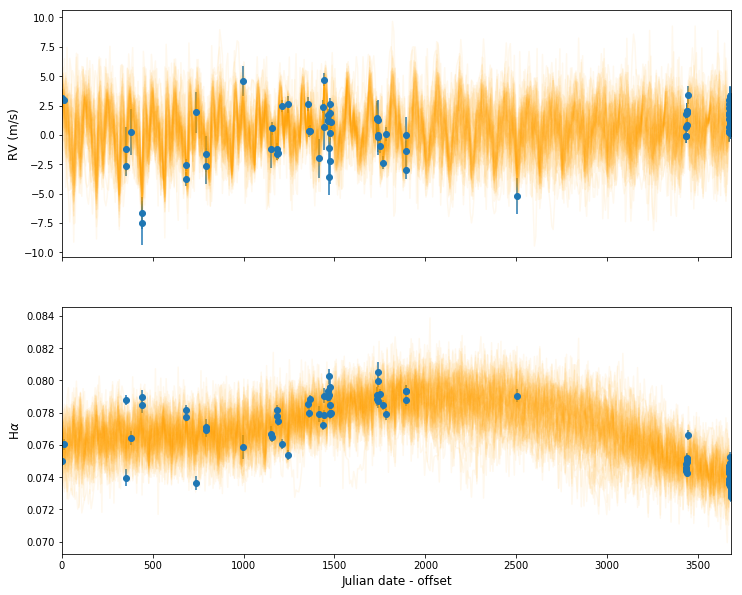

In [12]:
# Make a flat chain of samples with the initial burn-in discarded
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))

# Plot 50 possible RV curves drawn from the flat chain, along with the data
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,10))
tt = np.linspace(alldates[0], alldates[-1], 501, endpoint=True)



for i in range(50):
    # Choose a sample
    n = np.random.randint(0, samples.shape[0])
    spars_RV, spars_ha = split_par_vec(samples[n])
    gp_RV.set_parameter_vector(spars_RV)
    gp_ha.set_parameter_vector(spars_ha)
    # Plot a single sample.
    ax1.plot(tt, gp_RV.sample_conditional(allRV, tt), "orange", alpha=0.07)
    ax2.plot(tt, gp_ha.sample_conditional(allha, tt), "orange", alpha=0.07)
# Plot the real data
ax1.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax2.errorbar(alldates, allha, yerr=allhaerr, fmt='o')
ax2.set_xlim(alldates[0], alldates[-1])
ax2.set_xlabel("Julian date - offset", fontsize='large')
ax1.set_ylabel("RV (m/s)", fontsize='large')
ax2.set_ylabel(r"H$\alpha$", fontsize='large')

Strongest period signal in RV residuals: 21.51990543500902
False Alarm Prob.: 0.28700000000000003


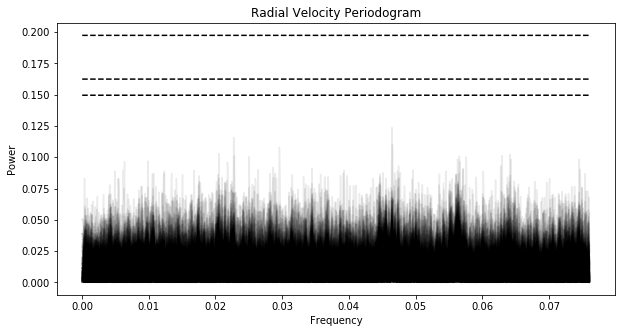

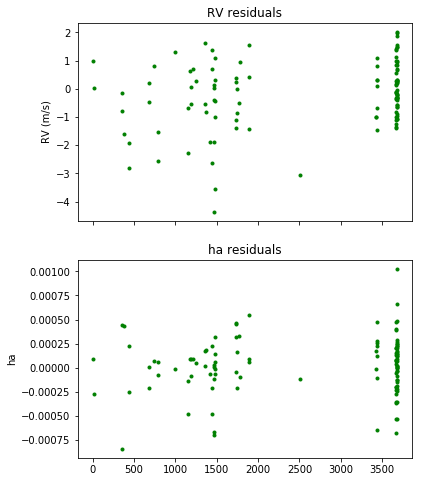

In [13]:
size = 300
RV_pds = np.zeros(size)
RV_pwr = np.zeros(size)
RV_fa = np.zeros(size)
ha_pds = np.zeros(size)
ha_pwr = np.zeros(size)
ha_fa = np.zeros(size)
fig, (ax1) = plt.subplots(1, sharex=False, figsize=(10,5)) #(width,height)
for r in range(size):

    #get residuals
    resid = allRV - gp_RV.sample_conditional(allRV,alldates)
    
    #periodogram
    ls = LombScargle(alldates, resid, allRVerr)
    xi, pspec = ls.autopower()
    sub = np.argmax(pspec)
    RV_pds[r] = 1.0/xi[sub]
    RV_pwr[r] = pspec[sub]
    
    #repeat for ha
    resida = allha - gp_ha.sample_conditional(allha,alldates)
    
    #plot
    ax1.plot(xi, pspec, 'k-', alpha=0.08)   
    
    
fig, (ax3, ax4) = plt.subplots(2, sharex=True, figsize=(6,8))
ax3.plot(alldates, resid,'g.')
ax3.set_title('RV residuals')
ax3.set_ylabel("RV (m/s)")
ax4.plot(alldates, resida,'g.')
ax4.set_title('ha residuals')
ax4.set_ylabel("ha")


probabilities = [0.05, 0.01, 0.1]
levels = ls.false_alarm_level(probabilities, method='bootstrap')
level1 = np.zeros(len(xi))
level2 = np.zeros(len(xi))
level3 = np.zeros(len(xi))
for i in range(len(level1)):
    level1[i]= levels[0]
    level2[i] = levels[1]
    level3[i] = levels[2]
ax1.plot(xi,level1,'k--')
ax1.plot(xi,level2,'k--')
ax1.plot(xi,level3,'k--')


    
ax1.set_xlabel("Frequency")
ax1.set_title("Radial Velocity Periodogram")
ax1.set_ylabel("Power")

idx1 = np.argmax(RV_pwr)
print('Strongest period signal in RV residuals:',RV_pds[idx1])
print('False Alarm Prob.:', ls.false_alarm_probability(RV_pwr[idx1],method = 'bootstrap'))


### 6. Examine posteriors and covariances:

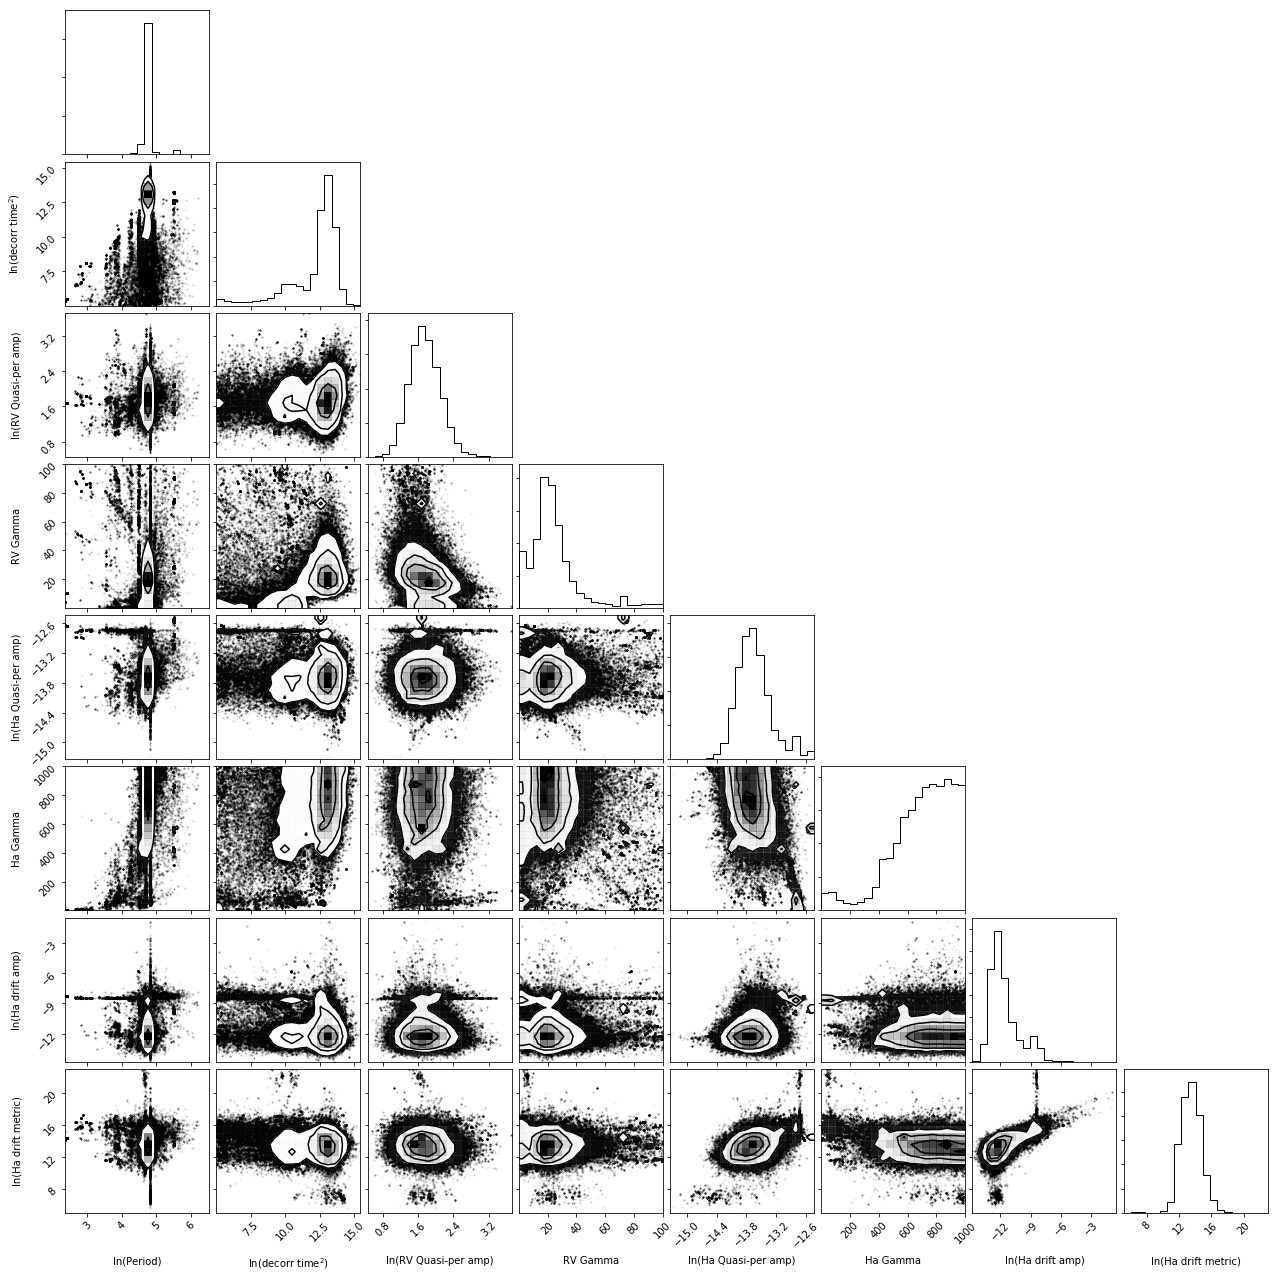

In [14]:
import corner
parnames = ["ln(Period)", "ln(decorr time$^2$)", "ln(RV Quasi-per amp)", \
            "RV Gamma", "ln(Ha Quasi-per amp)", "Ha Gamma", "ln(Ha drift amp)", \
            "ln(Ha drift metric)"]
cfig = corner.corner(samples, labels=parnames)

Bin containing most probable period: 123.8 -- 135.2 days
Bin containing most probable decorrelation time: 685.8 -- 741.9 days
Bin containing 2nd most probable decorrelation time: 573.5 -- 629.6 days

Period: 16, 50, 84 percentiles = 108.70 124.47 124.78 days
Decorrelation time: 16, 50, 84 percentiles = 172.17 591.14 829.16 days

Period = 124.47 +0.31 -15.77 days
Decorrelation time = 591.14 +238.02 -418.97 days


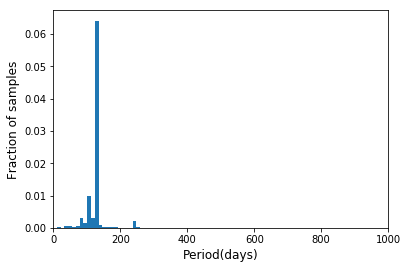

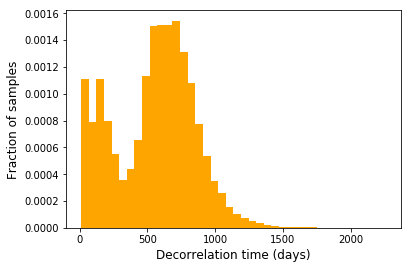

In [15]:
# Plots
plt.figure()
periods = np.exp(samples[:,0])
dctimes = np.exp(0.5*samples[:,1])
n_per, bins_per, _ = plt.hist(periods, 60, density=True)
plt.xlabel("Period(days)", fontsize='large')
plt.ylabel("Fraction of samples", fontsize='large')
plt.xlim([0,1000])
plt.figure()
n_dc, bins_dc, _ = plt.hist(dctimes, 40, density=True, facecolor='orange')
plt.xlabel("Decorrelation time (days)", fontsize='large')
plt.ylabel("Fraction of samples", fontsize='large')

# Numbers
per_bestbin = np.argmax(n_per)
dc_bestbin = np.argmax(n_dc)
dc_sort = np.argsort(n_dc)
print("Bin containing most probable period: %4.1f -- %4.1f days" \
      % (bins_per[per_bestbin], bins_per[per_bestbin+1]))
print("Bin containing most probable decorrelation time: %4.1f -- %4.1f days" \
      % (bins_dc[dc_bestbin], bins_dc[dc_bestbin+1]))
print("Bin containing 2nd most probable decorrelation time: %4.1f -- %4.1f days" \
      % (bins_dc[dc_sort[-2]], bins_dc[dc_sort[-2]+1]))
pctiles = [16, 50, 84]
pervals = np.percentile(periods, pctiles)
dcvals = np.percentile(dctimes, pctiles)
print("\nPeriod: 16, 50, 84 percentiles = %4.2f %4.2f %4.2f" \
      % (pervals[0], pervals[1], pervals[2]), "days")
print("Decorrelation time: 16, 50, 84 percentiles = %4.2f %4.2f %4.2f" \
      % (dcvals[0], dcvals[1], dcvals[2]), "days")

# Amusing myself with python's crazy way of interpreting lists and tuples
# Now I have a fun formatting example for future reference! (adapted from
# emcee tutorial)
po, dco = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),\
              zip(*np.percentile(np.column_stack((periods, dctimes)), \
              pctiles, axis=0)))
print("\nPeriod = %4.2f +%4.2f -%4.2f" % po, "days")
print("Decorrelation time = %4.2f +%4.2f -%4.2f" % dco, "days")

Text(0.5,0,'Step number')

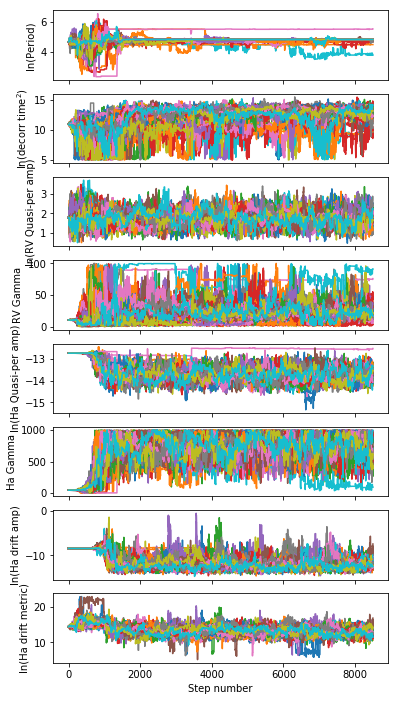

In [16]:
fig, axarr = plt.subplots(8, sharex=True, figsize=(6,12))
nsteps = nburn + nproduce
step = range(nsteps)
for i in range(len(axarr)):
    for w in range(nwalkers):
        axarr[i].plot(step, sampler.chain[w,:,i])
    axarr[i].set_ylabel(parnames[i])
axarr[7].set_xlabel('Step number')

In [17]:
#calculate reduced chi^2 value of model (average from a number of samples)
N = len(alldates)
n = 100
chi = np.zeros(n)
for i in range(n):
    resid = allRV - gp_RV.sample_conditional(allRV,alldates)
    s = np.square(resid)/(np.square(allRVerr))
    s = np.sum(s)
    chi[i] = s/(N-npars-1)
print(np.mean(chi))

1.9466820861411722


Text(0.5,1,'BIC Distribution')

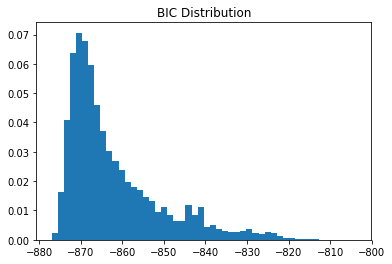

In [18]:
nsamples = nwalkers * nproduce
bics = np.zeros(nsamples)
for i in range(nsamples):
    bics[i] = np.log(npts) * npars + 2.*nll(samples[i,:])
n_bics, bins_bics, _ = plt.hist(bics, 50, density=True)
plt.title("BIC Distribution")